# テキストマイニングによるTwitter個人アカウントの性格推定  

- 2018-09-17 PyCon JP 2018
- @jumpyoshim ([Twitter](https://twitter.com/jumpyoshim)/[Qiita](https://qiita.com/jumpyoshim)/[GitLab](https://gitlab.com/jumpyoshim)/[はてなブログ](https://jumpyoshim.hatenablog.com/)) / 吉村 潤平
- iRidge, Inc. - Gold Sponsor

<div align="center">
<img src="images/kataomoi_woman.png">
</div>

<div align="center">
<img src="images/pose_atama_kakaeru_woman.png">
</div>

# 　　　　「あなたのこともっと知りたい...」

<div align="center">
<img src="images/Python_logo_and_wordmark.svg">
</div>

# 目次
- ツイートの収集
- 文書分類器の作成
  - 形態素解析
  - 特徴ベクトル
  - 機械学習

# ツイートの収集

[requests - PyPI](https://pypi.org/project/requests/)
---
> Requests is the only Non-GMO HTTP library for Python, safe for human consumption.

[urllib.request](https://docs.python.jp/3/library/urllib.request.html)
---
> The urllib.request module defines functions and classes which help in opening URLs (mostly HTTP) in a complex world — basic and digest authentication, redirections, cookies and more.

[python-twitter - PyPI](https://pypi.org/project/python-twitter/)
---
> A Python wrapper around the Twitter API. 

In [1]:
import twitter
from ipython_secrets import get_secret

CONSUMER_KEY = get_secret('CONSUMER_KEY')
CONSUMER_SECRET = get_secret('CONSUMER_SECRET')
ACCESS_TOKEN_KEY = get_secret('ACCESS_TOKEN_KEY')
ACCESS_TOKEN_SECRET = get_secret('ACCESS_TOKEN_SECRET')

api = twitter.Api(
    consumer_key=CONSUMER_KEY,
    consumer_secret=CONSUMER_SECRET,
    access_token_key=ACCESS_TOKEN_KEY,
    access_token_secret=ACCESS_TOKEN_SECRET
)

tweets = api.GetUserTimeline(screen_name='jumpyoshim', count=2)
tweets

[Status(ID=1039667226767314945, ScreenName=jumpyoshim, Created=Wed Sep 12 00:09:17 +0000 2018, Text='RT @endo__k: 最後に書かせていただきました〜/ぐるなび×GitLab×Rancher ~Deep Dive~ - ぐるなびをちょっと良くするエンジニアブログ https://t.co/qHOiXugadm'),
 Status(ID=1037654842762702848, ScreenName=jumpyoshim, Created=Thu Sep 06 10:52:47 +0000 2018, Text='RT @makotofalcon: ねぇ愚痴っていいですか?\n今俺がいる部署200人ぐらいいるのですがその中の管理職メンバーが、おれがVRゴーグルつけてお仕事をしていることを評価会議で糾弾してたらしいんですよ。全てお仕事なのですが?お前はスマホのアプリ作る時にスマホを見ずにアプ…')]

# 文章のベクトル化

[Bag-of-Words（BoW）](https://tifana.ai/words/natural-language-processing/9302.html)
---
> ベクトル表現の一種。 文章に単語が含まれるかどうかのみを考え、単語の並び方などは考慮しない形式のこと。

[Word2Vec - DeepAge](https://deepage.net/bigdata/machine_learning/2016/09/02/word2vec_power_of_word_vector.html)
---
> 単語の意味や文法を捉えるために単語をベクトル表現化して次元を圧縮したもの

[Doc2Vec - DeepAge](https://deepage.net/machine_learning/2017/01/08/doc2vec.html)
---
> 任意の長さの文書をベクトル化する技術で、文やテキストに対して分散表現（Document Embeddings）を獲得することができる。

# 形態素解析

[形態素解析 - Wikipedia](https://ja.wikipedia.org/wiki/%E5%BD%A2%E6%85%8B%E7%B4%A0%E8%A7%A3%E6%9E%90)
---
> 形態素解析（けいたいそかいせき、Morphological Analysis）とは、文法的な情報の注記の無い自然言語のテキストデータ（文）から、対象言語の文法や、辞書と呼ばれる単語の品詞等の情報にもとづき、形態素（Morpheme, おおまかにいえば、言語で意味を持つ最小単位）の列に分割し、それぞれの形態素の品詞等を判別する作業である

In [2]:
import MeCab

text = 'すもももももももものうち'

tagger = MeCab.Tagger('mecabrc')
print(tagger.parse(text))

すもも	名詞,一般,*,*,*,*,すもも,スモモ,スモモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
うち	名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ
EOS



[mecab-python3 - PyPI](https://pypi.org/project/mecab-python3/)
---
> This python wrapper for mecab works on both python3.x and python2.x.


[Janome - PyPI](https://pypi.org/project/Janome/)
---
> Janome is a Japanese morphological analysis engine written in pure Python.

[JUMAN - Wikipedia](https://ja.wikipedia.org/wiki/JUMAN)
---
> JUMANは、日本語の形態素解析システム。京都大学黒橋・河原研究室で開発されている。
人手で整備した辞書に基づいており、...

In [3]:
import MeCab

from lib.regex import replace_substring

tagger = MeCab.Tagger('mecabrc')
data = []
for tweet in tweets:
    text = replace_substring(tweet.text)
    node = tagger.parseToNode(text)
    words = []
    while node:
        meta = node.feature.split(',')
        if meta[0] == '名詞':
            words.append(node.surface.lower())
        node = node.next
    data.append(words)
print(data)

[['rt', ':', '最後', '/', 'ぐる', 'び', 'gitlab×rancher', '~', 'deepdive', '~-', 'ぐる', 'びをちょっと', 'エンジニアブログ'], ['rt', ':', '?', '今', '俺', '部署', '200', '人', 'の', '中', '管理', '職', 'メンバー', 'おれ', 'vr', 'ゴーグル', '仕事', 'こと', '評価', '会議', '糾弾', 'ん', '全て', '仕事', 'の', '?', 'お前', 'スマホ', 'アプリ', '時', 'スマホ', 'アプ']]


# 特徴ベクトル

[gensim - PyPI](https://pypi.org/project/gensim/)
---
> Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community.

In [4]:
from gensim import corpora, matutils

dictionary = corpora.Dictionary(data)
data_train = []
for datum in data:
    bow = dictionary.doc2bow(datum)
    dense = list(matutils.corpus2dense([bow], num_terms=len(dictionary)).T[0])
    data_train.append(dense)
print(data_train)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]


# 機械学習

[エゴグラム - Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%A8%E3%82%B4%E3%82%B0%E3%83%A9%E3%83%A0)
---
> エゴグラム (Egogram) とは、エリック・バーン (Eric Berne) の交流分析における自我状態をもとに、弟子であるジョン・M・デュセイ (John M. Dusay) が考案した性格診断法で、**人の心を5つに分類し、その5つの自我状態が放出する心的エネルギーの高さをグラフにしたもののこと** である


- CP(Critical Parent)：支配性
- NP(Nurturing Parent)：寛容性
- A(Adult)：論理性
- FC(Free Child)：奔放性
- AC(Adapted Child)：順応性

質問紙法
---
- 5要素のそれぞれに関する質問が10問程度ずつ、全部で50問程度の質問に答えていき、最後にそれを集計し、点数化したものを、CP、NP、A、FC、ACの順に点数をもとに点を打っていき、グラフにする

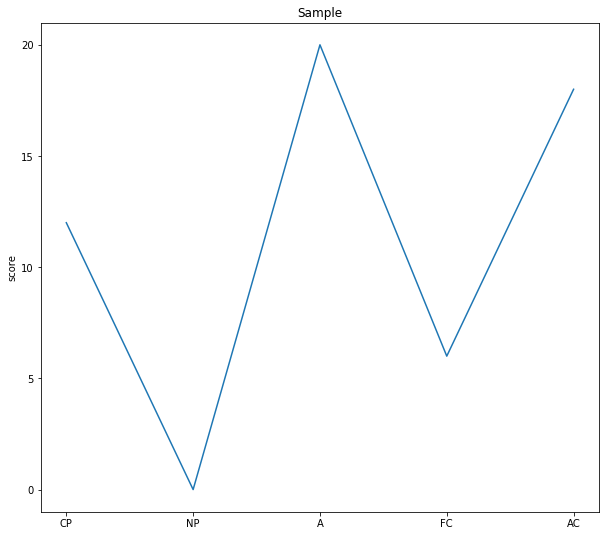

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 9))
plt.title('Sample')
plt.ylabel('score')
plt.plot([12, 0, 20, 6, 18])
plt.xticks([0, 1, 2, 3, 4], ['CP', 'NP', 'A', 'FC', 'AC'])
plt.yticks([0, 5, 10, 15, 20])
plt.show()

# [分類パターン](http://www.egogram-f.jp/seikaku/aisyou/patan.htm)
- ネクラ厭世タイプ（Ｗ型）
- 明朗楽観タイプ（Ｍ型）
- 優柔不断タイプ（Ｎ型）
- ハイパワータイプ（逆Ｎ型）
- 頭でっかちタイプ（逆Ｖ型）
- お手あげタイプ（Ｖ型）
- 典型的ネクラタイプ（Ｕ型）
- ぼんぼんタイプ（逆Ｕ型）
- 頑固オヤジタイプ（左上がり型）
- ガキ丸出しタイプ（右上がり型）
- ハイレベルタイプ（オールＡ型）

- 中庸タイプ（オールＢ型）
- 原始人タイプ（オールＣ型）
- ルーズタイプ（ＣＰ欠乏型）
- クールタイプ（ＮＰ欠乏型）
- 現実無視タイプ（Ａ欠乏型）
- 自閉症タイプ（ＦＣ欠乏型）
- 気ままタイプ（ＡＣ欠乏型）
- 口うるさタイプ（ＣＰ型）
- お人好しタイプ（ＮＰ型）
- コンピュータタイプ（Ａ型）
- 自由奔放タイプ（ＦＣ型）
- 自己卑下タイプ（ＡＣ型）

# [scikit-learn](https://pypi.org/project/scikit-learn/)
> scikit-learn is a Python module for machine learning built on top of SciPy and distributed under the 3-Clause BSD license.

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
label_train = ['ネクラ厭世タイプ（Ｗ型）', '明朗楽観タイプ（Ｍ型）']
clf.fit(data_train, label_train)
clf.predict(data_train)

array(['ネクラ厭世タイプ（Ｗ型）', '明朗楽観タイプ（Ｍ型）'], dtype='<U12')

# [@PyConJ](https://twitter.com/PyConJ)の性格を推定してみよう

<div align="center">
<img src="images/PyConJ.png">
</div>

In [ ]:
from sklearn.externals import joblib

from lib.twitter import get_user_timeline

# ツイートの収集
tweets = get_user_timeline(api, 'PyConJ')

# 形態素解析（名詞の抽出）
node = tagger.parseToNode(tweets)
words = []
while node:
    meta = node.feature.split(',')
    if meta[0] == '名詞':
        words.append(node.surface.lower())
    node = node.next
    
# ベクトル化
dictionary = corpora.Dictionary.load_from_text('Dictionary.txt')
bow = dictionary.doc2bow(words)
dense = list(matutils.corpus2dense([bow], num_terms=len(dictionary)).T[0])

# 機械学習
clf = joblib.load('egogram.pkl')
clf.predict([dense]) 

# 参考文献
- [scikit-learnとgensimでニュース記事を分類する - Qiita](https://qiita.com/yasunori/items/31a23eb259482e4824e2)
- [SVMによる文書分類とその応用](https://qiita.com/3000manJPY/items/a0652d488ce3c956613d)